<center><h1>McGill University ECSE 444 Microprocessor</h1>
<h2>Final Project - Human Motion Recognition (HMR)</h2></center>

&nbsp;
## I - Load Dataset
with TensorFlow 2.14.0, X-CUBE-AI v8.1.0

In [6]:
# @version      0.8
# @author       A. Wei, A. Xu, F. Zhang, Z. Zhang
# @description  A CNN-based model training algorithm designed for HMR, used to classify data from I2C accelerometers

import os
import glob
import chardet
import numpy as np
import pandas as pd
import keras.layers as layers
import keras.utils as utils
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [7]:
PATH = './olympics'
states = [i for i in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, i))]
# if statement ensures only folders are selected (macOS creates these .DS_Store)
NUM_STATE = len(states)

for subdir in os.listdir(PATH):
    sub = os.path.join(PATH, subdir)
    if os.path.isdir(sub):
        for file in os.listdir(sub):
            if file.endswith('.csv'):
                file_path = os.path.join(sub, file)
                # unify encoding to us-ascii
                with open(file_path, 'rb') as f:
                    result = chardet.detect(f.read())
                df = pd.read_csv(file_path, encoding = result['encoding'])
                # remove invalid rows
                df.dropna(subset = [df.columns[1], df.columns[2]], inplace = True, how = 'any')
                df.to_csv(file_path, encoding = 'ascii', index = False, errors = 'replace')

label, files, data, = [], [], []
for lbl, state in enumerate(states):
    for file in glob.glob(f'olympics/{state}/*.csv'):
        label.append(lbl)
        files.append(file)
        data.append(np.loadtxt(file, delimiter = ',').reshape(-1, 3).astype(np.int16))  # data range [-4000, 4000]
label = np.array(label)
label_1hot = utils.to_categorical(label, num_classes = NUM_STATE)
# print(data.shape)

&nbsp;
## II - Ready the Frames
a simple standardization should suffice for this project

In [8]:
# 1 frame represents 1 second, with conventional 50% overlap
FRAME_LEN, HOP = 26, 13

# each recording captured into smaller frames (input for CNN later)
lbl_frame, data_frame = [], []
for file in range(len(data)):
    num_frame = (data[file].shape[0] - FRAME_LEN) // HOP + 1
    if num_frame > 0:
        shape = (num_frame, FRAME_LEN, 3)
        stride = ((HOP * data[file].strides[0],) + data[file].strides)
        frame = np.lib.stride_tricks.as_strided(data[file], shape = shape, strides = stride)
        data_frame.append(frame)
        lbl_frame.append(np.full((frame.shape[0], NUM_STATE), label_1hot[file]))

lbl_frame, data_frame = np.concatenate(lbl_frame), np.concatenate(data_frame)
# print(data_frame.shape)
# print(lbl_frame.shape)

# input normalized & shuffled (default)
data_trn, data_tst, lbl_trn, lbl_tst = train_test_split(data_frame / 4000, lbl_frame, test_size = 0.2) # REFERENCE [1]

&nbsp;
## III - Training
creating a classifier with Keras

In [9]:
%%time
model = Sequential([    # REFERENCE [1]
    layers.Conv1D(filters = 64, kernel_size = 5, input_shape = (26, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(filters = 32, kernel_size = 5),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(NUM_STATE, activation = 'softmax')
])

# use focal loss due to the imbalanced nature of our dataset
model.compile(loss = 'categorical_focal_crossentropy', optimizer = 'RMSprop', metrics = ['acc'])
model.fit(data_trn, lbl_trn, epochs = 15)

Epoch 1/15
246/246 [==============================] - 2s 5ms/step - loss: 0.0607 - acc: 0.7984
Epoch 2/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0266 - acc: 0.9016
Epoch 3/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0198 - acc: 0.9207
Epoch 4/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0162 - acc: 0.9381
Epoch 5/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0138 - acc: 0.9460
Epoch 6/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0115 - acc: 0.9570
Epoch 7/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0106 - acc: 0.9582
Epoch 8/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0100 - acc: 0.9654
Epoch 9/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0087 - acc: 0.9663
Epoch 10/15
246/246 [==============================] - 1s 5ms/step - loss: 0.0089 - acc: 0.9677
Epoch 11/15
246/246 [============================

&nbsp;
## IV - Deliver

62/62 [==============================] - 0s 2ms/step


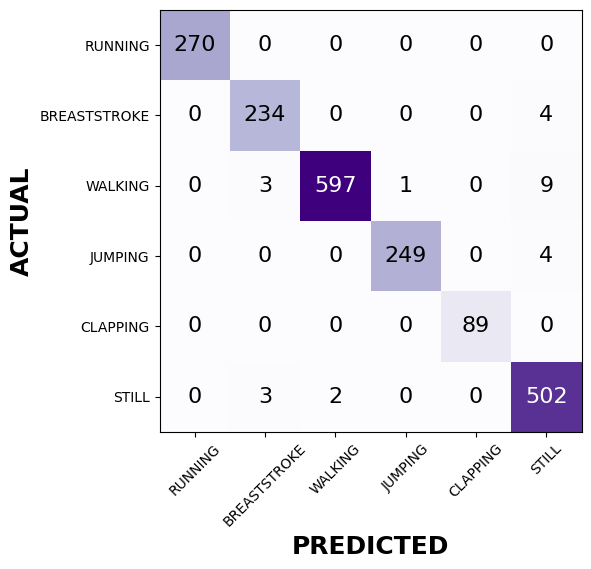

Accuracy-OVERALL: 98.7%
Accuracy-RUNNING: 100.00%
Accuracy-BREASTSTROKE: 98.32%
Accuracy-WALKING: 97.87%
Accuracy-JUMPING: 98.42%
Accuracy-CLAPPING: 100.00%
Accuracy-STILL: 99.01%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
pred = np.argmax(model.predict(data_tst), axis = 1)
truth = np.argmax(lbl_tst, axis = 1)
ct = confusion_matrix(truth, pred)

# visual accuracies
plt.figure(figsize = (6, 6))
plt.imshow(ct, cmap = plt.cm.Purples)
plt.grid(False)
# ignore cbar saturation since the dataset is imbalanced
plt.xticks(np.arange(NUM_STATE), states, rotation = 45)
plt.yticks(np.arange(NUM_STATE), states)
plt.xlabel('PREDICTED', weight = 'bold', fontsize = 18)
plt.ylabel('ACTUAL', weight = 'bold', fontsize = 18)
for i in range(ct.shape[0]):  # display number of occurrence in cells
    for j in range(ct.shape[1]):
        plt.text(j, i, ct[i, j], fontsize = 16,
                 horizontalalignment = "center",
                 verticalalignment = "center",
                 # guarantee contrast for visibility. REFERENCE [3]
                 color = "w" if ct[i, j] > ct.max() / 2 else "k")
plt.tight_layout()
plt.show()

# numerical accuracies (individual & overall)
print(f"Accuracy-OVERALL: {accuracy_score(truth, pred) * 100:.1f}%")
print()
for lbl in range(NUM_STATE):
    msk = truth == lbl
    print(f"Accuracy-{states[lbl]}: {accuracy_score(truth[msk], pred[msk]) * 100:.2f}%")

model.save('HMR.h5')    # auto overwrite to current directory

&nbsp;
## References
1. **stm32ai-wiki: git repo to illustrates and supports the STM32 AI wiki articles.** (n.d. -b). GitHub.
    - [STMicroelectronics](https://github.com/STMicroelectronics/stm32ai-wiki/tree/master)
    - (accessed Nov. 8th, 2023)
2. Jaén-Vargas, M., Leiva, K. M. R., Fernandes, F., Gonçalves, S. B., Silva, M. T., Lopes, D. S., & Olmedo, J. J. S. (2022). Effects of sliding window variation in the performance of acceleration-based human activity recognition using deep learning models. PeerJ Computer Science, 8, e1052.
3. **How change the color of boxes in confusion matrix using sklearn?** (n.d.). StackOverflow.
    - [Stack Overflow](https://stackoverflow.com/questions/57043260/how-change-the-color-of-boxes-in-confusion-matrix-using-sklearn)
    - (accessed Nov. 12th, 2023)